# November ??th, 2021 (corr distributions)

**Motivation**: Dufferent approaches to sparsify <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [3]:
# HIDE CODE


def show_corrs(key):
    try:
        net_ca = Network(mice, key, 'ca2').load_network()
        net_bold = Network(mice, key, 'bold-lite').load_network()
    except TypeError:
        return 
    
    fig, axes = create_figure(2, 4, (12.8, 6))

    for i, _net in enumerate([net_bold, net_ca]):
        xl = _net.adj[_net.l_ids][:, _net.l_ids]
        xr = _net.adj[_net.r_ids][:, _net.r_ids]
        vmin = np.min(_net.adj)
        vmax = np.max(_net.adj)

        j = 2 * i
        im = axes[0, j].imshow(xl, vmin=vmin, vmax=vmax, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[0, j], shrink=0.75)
        axes[0, j].set_title(f"{_net.mode} (left hemis)")

        j = 2 * i + 1
        im = axes[0, j].imshow(xr, vmin=vmin, vmax=vmax, cmap='Spectral_r')
        plt.colorbar(im, ax=axes[0, j], shrink=0.75)
        axes[0, j].set_title(f"{_net.mode} (right hemis)")

        j = 2 * i
        sns.histplot(
            data=xl[xl.nonzero()],
            label='left hemis',
            stat='percent',
            color='C0',
            bins=30,
            alpha=0.7,
            ax=axes[1, j],
        )
        sns.histplot(
            data=xr[xr.nonzero()],
            label='right hemis',
            stat='percent',
            color='C3',
            bins=30,
            alpha=0.7,
            ax=axes[1, j],
        )
        axes[1, j].set_xlabel('correlation')
        axes[1, j].set_title(f"{_net.mode} corr hist")
        axes[1, j].legend()

        j = 2 * i + 1
        sns.ecdfplot(
            data=xl[xl.nonzero()],
            label='left hemis',
            color='C0',
            lw=2,
            ax=axes[1, j],
        )
        sns.ecdfplot(
            data=xr[xr.nonzero()],
            label='right hemis',
            color='C3',
            lw=2,
            ax=axes[1, j],
        )
        axes[1, j].set_xlabel('correlation')
        axes[1, j].set_title(f"{_net.mode} corr ecdf")
        axes[1, j].legend()
        axes[1, j].grid()
    fig.suptitle(key, fontsize=15, y=1.03)
    plt.show()
    
    return (net_ca, net_bold), (fig, axes)

In [4]:
mice = Mice((100, 3))

In [6]:
key = 'sub-SLC02_ses-1_run-1'
net_ca = Network(mice, key, 'ca2').load_network()
net_bold = Network(mice, key, 'bold-lite').load_network()

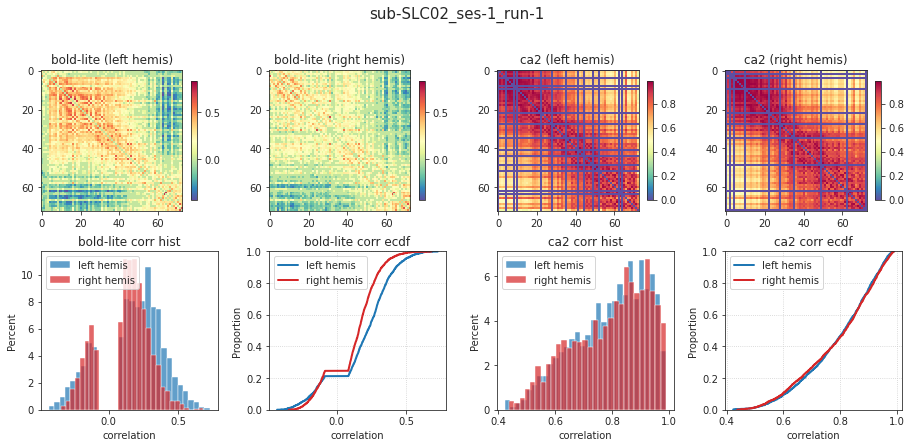

In [7]:
_ = show_corrs(key)

In [105]:
def calculate_threshold(a: np.ndarray, d: float, verbose: bool = False):
    nonzero = np.abs(a).mean(0) > 0
    adj_eff = a[nonzero][:, nonzero]
    y = sp_dist.squareform(adj_eff)
    thres = np.quantile(y, 1 - d)

    if verbose:
        adj_eff[adj_eff <= thres] = 0.
        g = nx.from_numpy_matrix(adj_eff)
        msg = f"threshold = {thres:0.2f}\t/\t"
        msg += f"density:  requested = {d:0.5f}, "
        msg += f"result = {nx.density(g):0.5f};\n"
        print(msg)
    
    return thres

In [106]:
thres = calculate_threshold(net_ca.adj, 0.1, True)

threshold = 0.94        /       density:  requested = 0.10000, result = 0.10009;

In [109]:
absolute = {}
density = {}
for key in mice.ca:
    net = Network(mice, key, 'ca2').load_network()

{
    'sub-SLC01_ses-1_run-1': <model.dataset.FuncData object at 0x7f5c40dfbbb0>,
    'sub-SLC01_ses-1_run-3': <model.dataset.FuncData object at 0x7f5cf4482100>,
    'sub-SLC01_ses-1_run-5': <model.dataset.FuncData object at 0x7f5cf4482040>,
    'sub-SLC01_ses-1_run-7': <model.dataset.FuncData object at 0x7f5cf44bad00>,
    'sub-SLC01_ses-2_run-1': <model.dataset.FuncData object at 0x7f5c40f6cd30>,
    'sub-SLC01_ses-2_run-3': <model.dataset.FuncData object at 0x7f5c40f6cd00>,
    'sub-SLC01_ses-2_run-5': <model.dataset.FuncData object at 0x7f5c40f6c820>,
    'sub-SLC01_ses-2_run-7': <model.dataset.FuncData object at 0x7f5c40f6c4f0>,
    'sub-SLC01_ses-3_run-1': <model.dataset.FuncData object at 0x7f5cca2016a0>,
    'sub-SLC01_ses-3_run-3': <model.dataset.FuncData object at 0x7f5c67202be0>,
    'sub-SLC01_ses-3_run-5': <model.dataset.FuncData object at 0x7f5c40f6c4c0>,
    'sub-SLC01_ses-3_run-7': <model.dataset.FuncData object at 0x7f5cf6d48100>,
    'sub-SLC02_ses-1_run-1': <model.dataset.FuncData object at 0x7f5c40fc1b50>,
    'sub-SLC02_ses-1_run-3': <model.dataset.FuncData object at 0x7f5c40fc1f10>,
    'sub-SLC02_ses-1_run-5': <model.dataset.FuncData object at 0x7f5c40fc15e0>,
    'sub-SLC02_ses-1_run-7': <model.dataset.FuncData object at 0x7f5c40f6c490>,
    'sub-SLC02_ses-2_run-1': <model.dataset.FuncData object at 0x7f5cf44ba5b0>,
    'sub-SLC02_ses-2_run-3': <model.dataset.FuncData object at 0x7f5cf44ba610>,
    'sub-SLC02_ses-2_run-5': <model.dataset.FuncData object at 0x7f5c40dfebb0>,
    'sub-SLC02_ses-3_run-1': <model.dataset.FuncData object at 0x7f5c40dfedf0>,
    'sub-SLC02_ses-3_run-3': <model.dataset.FuncData object at 0x7f5c40f6c1f0>,
    'sub-SLC02_ses-3_run-5': <model.dataset.FuncData object at 0x7f5c40fc18e0>,
    'sub-SLC02_ses-3_run-7': <model.dataset.FuncData object at 0x7f5c40fc1e50>,
    'sub-SLC03_ses-1_run-1': <model.dataset.FuncData object at 0x7f5c40fc1b80>,
    'sub-SLC03_ses-1_run-2': <model.dataset.FuncData object at 0x7f5c40fc1a90>,
    'sub-SLC03_ses-1_run-4': <model.dataset.FuncData object at 0x7f5c40fc1190>,
    'sub-SLC03_ses-1_run-6': <model.dataset.FuncData object at 0x7f5c04720e80>,
    'sub-SLC03_ses-2_run-1': <model.dataset.FuncData object at 0x7f5c04727190>,
    'sub-SLC03_ses-2_run-3': <model.dataset.FuncData object at 0x7f5c67bc65b0>,
    'sub-SLC03_ses-2_run-5': <model.dataset.FuncData object at 0x7f5c40e62190>,
    'sub-SLC03_ses-2_run-7': <model.dataset.FuncData object at 0x7f5c40e62100>,
    'sub-SLC03_ses-3_run-1': <model.dataset.FuncData object at 0x7f5c40e620a0>,
    'sub-SLC03_ses-3_run-3': <model.dataset.FuncData object at 0x7f5c40e00fa0>,
    'sub-SLC03_ses-3_run-5': <model.dataset.FuncData object at 0x7f5cf44bf460>,
    'sub-SLC03_ses-3_run-7': <model.dataset.FuncData object at 0x7f5cf44bf880>,
    'sub-SLC04_ses-1_run-1': <model.dataset.FuncData object at 0x7f5c0472a730>,
    'sub-SLC04_ses-1_run-3': <model.dataset.FuncData object at 0x7f5c0472afa0>,
    'sub-SLC04_ses-1_run-5': <model.dataset.FuncData object at 0x7f5c0472ab20>,
    'sub-SLC04_ses-1_run-7': <model.dataset.FuncData object at 0x7f5c0472a4f0>,
    'sub-SLC04_ses-2_run-1': <model.dataset.FuncData object at 0x7f5c0472a970>,
    'sub-SLC04_ses-2_run-3': <model.dataset.FuncData object at 0x7f5cf44bf490>,
    'sub-SLC04_ses-2_run-5': <model.dataset.FuncData object at 0x7f5c40e00d60>,
    'sub-SLC04_ses-2_run-7': <model.dataset.FuncData object at 0x7f5c67bc68b0>,
    'sub-SLC04_ses-3_run-1': <model.dataset.FuncData object at 0x7f5cf4529eb0>,
    'sub-SLC04_ses-3_run-3': <model.dataset.FuncData object at 0x7f5cf6d9fc40>,
    'sub-SLC04_ses-3_run-5': <model.dataset.FuncData object at 0x7f5cf6d48c40>,
    'sub-SLC04_ses-3_run-7': <model.dataset.FuncData object at 0x7f5c40fc1310>,
    'sub-SLC05_ses-1_run-1': <model.dataset.FuncData object at 0x7f5c40fc1f70>,
    'sub-SLC05_ses-1_run-3': <model.dataset.FuncData object at 0x7f5c40f6c070>,
    'sub-SLC05_ses-1_run-5': <model.dataset.FuncData object at 0x7f5c40f6c5e0>